In [1]:
import geopandas as gpd
import pandas as pd
import geobr
import matplotlib.pyplot as plt
import numpy as np
from shapely.wkt import loads as load_wkt
from shapely.geometry import Point
import matplotlib.lines as mlines

In [2]:
#Leitura dos dados utilizados
df_geobr = geobr.read_municipality(code_muni='all', year=2018)
df_estados = geobr.read_state(code_state='all', year=2018)

In [3]:
#Pegando apenas as colunas que correspondem ao código e o shape do município
colunas = ['code_muni', 'geometry']
df_geobr = df_geobr[colunas]
df_geobr

,code_muni,geometry
0,1100015.0,"MULTIPOLYGON (((-62.23224 -11.90804, -62.20670..."
1,1100023.0,"MULTIPOLYGON (((-63.57327 -9.78326, -63.57016 ..."
2,1100031.0,"MULTIPOLYGON (((-60.71834 -13.39058, -60.70904..."
3,1100049.0,"MULTIPOLYGON (((-61.27873 -11.50596, -61.28097..."
4,1100056.0,"MULTIPOLYGON (((-61.41347 -13.23417, -61.42603..."
...,...,...
5567,5222005.0,"POLYGON ((-48.53842 -16.75003, -48.54051 -16.7..."
5568,5222054.0,"POLYGON ((-50.00189 -17.78179, -50.01420 -17.7..."
5569,5222203.0,"POLYGON ((-47.07742 -15.06330, -47.07851 -15.0..."
5570,5222302.0,"POLYGON ((-48.91463 -15.20939, -48.91532 -15.1..."


In [4]:
#Retirando valores nulos
df_geobr = df_geobr.dropna()
df_geobr

,code_muni,geometry
0,1100015.0,"MULTIPOLYGON (((-62.23224 -11.90804, -62.20670..."
1,1100023.0,"MULTIPOLYGON (((-63.57327 -9.78326, -63.57016 ..."
2,1100031.0,"MULTIPOLYGON (((-60.71834 -13.39058, -60.70904..."
3,1100049.0,"MULTIPOLYGON (((-61.27873 -11.50596, -61.28097..."
4,1100056.0,"MULTIPOLYGON (((-61.41347 -13.23417, -61.42603..."
...,...,...
5567,5222005.0,"POLYGON ((-48.53842 -16.75003, -48.54051 -16.7..."
5568,5222054.0,"POLYGON ((-50.00189 -17.78179, -50.01420 -17.7..."
5569,5222203.0,"POLYGON ((-47.07742 -15.06330, -47.07851 -15.0..."
5570,5222302.0,"POLYGON ((-48.91463 -15.20939, -48.91532 -15.1..."


In [5]:
centroides = []
for linha in df_geobr.itertuples():
    poligono = load_wkt(str(linha.geometry))
    centroides.append(poligono.centroid)

In [6]:
df_centroides = pd.DataFrame()
df_centroides['geometry'] = centroides
df_centroides = gpd.GeoDataFrame(df_centroides)
df_centroides.crs = df_geobr.crs

In [7]:
centroides_estado = []
for linha in df_estados.itertuples():
    poligono = load_wkt(str(linha.geometry))
    centroides_estado.append(poligono.centroid)
    
coordenadas_estado = []
for point in centroides_estado:
    coordenadas_estado.append((point.x, point.y))
    
df_estados['centroides'] = coordenadas_estado

In [8]:
# Seleciona em 'casos_full.csv' apenas os atributos que vamos trabalhar
data = pd.read_csv('caso_full.csv')
data = data[['epidemiological_week','new_confirmed','new_deaths', 'place_type', 'city_ibge_code']]

In [9]:
# Filtra todas informações de estados e agrupa por semana epidemiológica
data_city = data[data['place_type']=='city']
data_city = data_city.groupby(['epidemiological_week', 'city_ibge_code']).sum()
data_city

new_confirmed  new_deaths
epidemiological_week city_ibge_code                           
9                    3550308.0                   2           0
10                   2910800.0                   2           0
                     3300407.0                   1           0
                     3304557.0                   1           0
                     3547304.0                   1           0
...                                            ...         ...
34                   5222005.0                  15           0
                     5222054.0                   8           1
                     5222203.0                   0           0
                     5222302.0                  11           0
                     5300108.0                5775         180

[84870 rows x 2 columns]

In [10]:
# Cria a coluna com o poligono representante de cada cidade e adiciona ela ao data_city
data_city.reset_index(inplace=True)
data_city = data_city.merge(df_geobr,how='inner', left_on='city_ibge_code', right_on='code_muni')
data_city

,epidemiological_week,city_ibge_code,new_confirmed,new_deaths,code_muni,geometry
0,9,3550308.0,2,0,3550308.0,"POLYGON ((-46.46934 -23.48106, -46.46047 -23.4..."
1,10,3550308.0,10,0,3550308.0,"POLYGON ((-46.46934 -23.48106, -46.46047 -23.4..."
2,11,3550308.0,50,0,3550308.0,"POLYGON ((-46.46934 -23.48106, -46.46047 -23.4..."
3,12,3550308.0,244,9,3550308.0,"POLYGON ((-46.46934 -23.48106, -46.46047 -23.4..."
4,13,3550308.0,738,53,3550308.0,"POLYGON ((-46.46934 -23.48106, -46.46047 -23.4..."
...,...,...,...,...,...,...
84865,34,5212253.0,0,0,5212253.0,"POLYGON ((-51.26407 -19.14078, -51.24725 -19.1..."
84866,33,5214903.0,1,0,5214903.0,"POLYGON ((-46.81122 -13.72583, -46.81906 -13.7..."
84867,34,5214903.0,0,0,5214903.0,"POLYGON ((-46.81122 -13.72583, -46.81906 -13.7..."
84868,34,4300638.0,2,0,4300638.0,"POLYGON ((-52.42149 -30.85093, -52.42791 -30.8..."


ValueError: s must be a scalar, or the same size as x and y

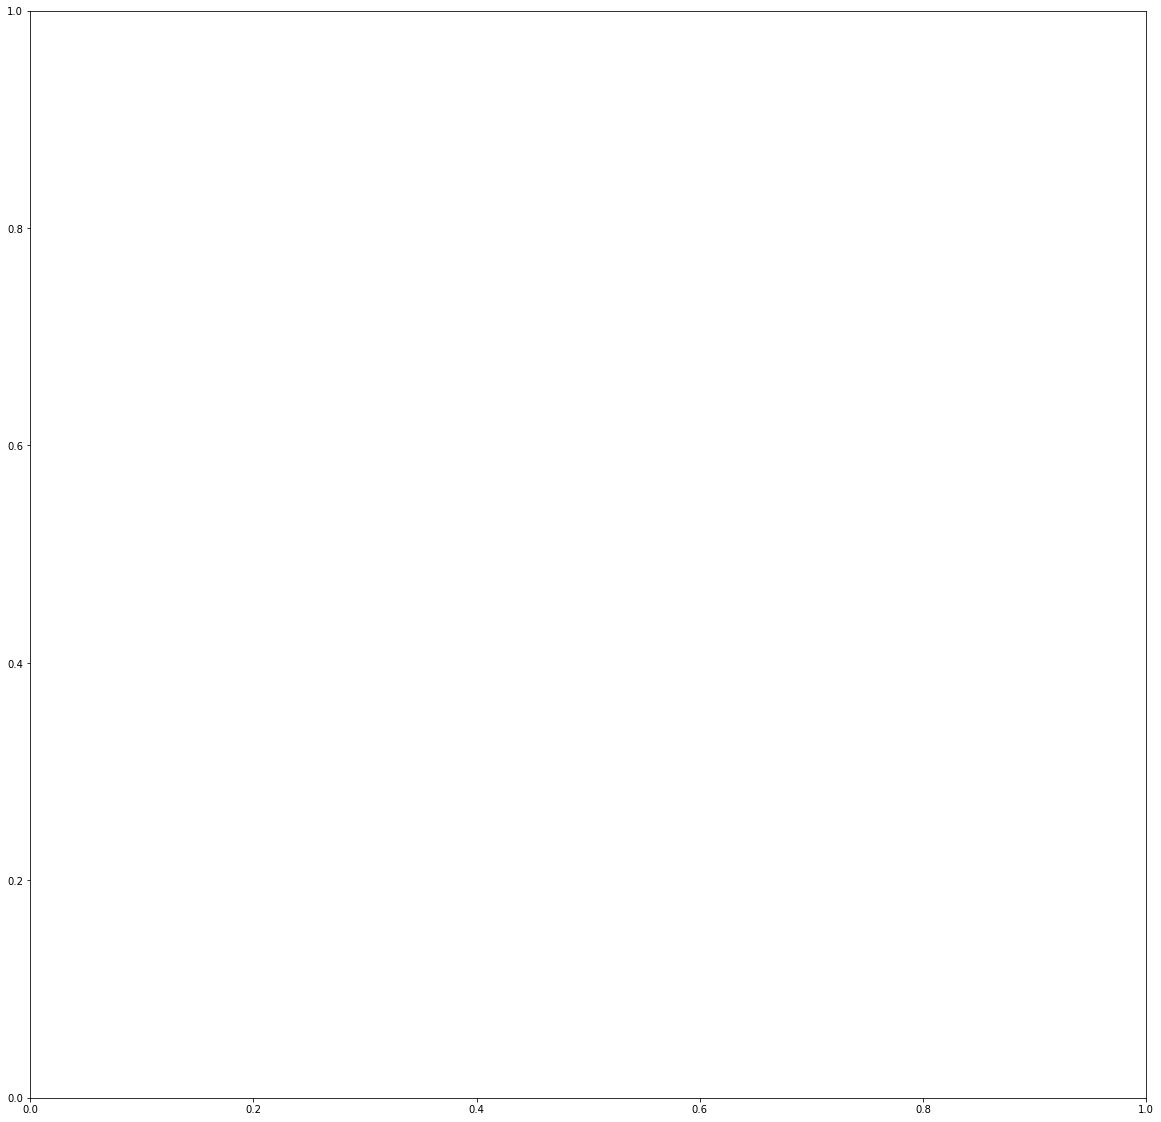

In [13]:
copy_geobr = data_city[data_city.epidemiological_week == 31]

markersize = []
for linha in copy_geobr.itertuples():
    markersize.append(linha.new_confirmed*1)

fig, ax = plt.subplots(figsize=(20, 20))

xs=[point.x for point in df_centroides['geometry']]
ys=[point.y for point in df_centroides['geometry']]
scatter = ax.scatter(xs, ys, markersize, alpha=0.6, color="#ff8400")

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, color='#ff8400', num=7)
del df_casos

In [ ]:
legend ='''ax.legend(handles, labels, title="Número de casos", loc=3,borderpad=3, labelspacing=2, handlelength=7, title_fontsize=25, fontsize=18, frameon=False)'''
for semana in range(9,32):
    df_casos = data_state[data_state.epidemiological_week == semana]
    copy_geobr = df_geobr.copy()
    copy_geobr = pd.merge(copy_geobr, df_casos, on='code_muni', how='left')
    copy_geobr.fillna(0, inplace=True)
    
    markersize = []
    for linha in copy_geobr.itertuples():
        markersize.append(linha.new_confirmed*1)
        
    fig, ax = plt.subplots(figsize=(20, 20))
    copy_geobr.plot(ax=ax, facecolor='#cccccc')
    df_estados.geometry.boundary.plot(color=None,edgecolor='#888888',linewidth = 2,ax=ax)

    ax.scatter(xs, ys, markersize, alpha=0.6, color="#ff8400")
    
    ax.annotate('', xy=(-35, -30), xytext=(-35, -33), arrowprops=dict(arrowstyle= '->', color='k', lw=2, mutation_scale=10))
    ax.text(-35, -30, "N", ha="center", va="bottom", size=20)
    ax.axis('off')
    
    for linha in df_estados.itertuples():
        plt.annotate(s=linha.abbrev_state, xy=linha.centroides, horizontalalignment='center', verticalalignment='center', fontsize=20)

    exec(legend)
    plt.title("Novos casos confirmados - Semana Epidemiológica {}".format(semana), fontsize=30)
    plt.savefig("mapa_casos_{}.png".format(semana))
    del df_casos